# **STINTSY Machine Project**

## *Group # - S16*
- **Ang, Danielle Faith** 
- **De Los Santos, Hanna Angela**
- **Robles, Luis Miguel**
- **Sarreal, Sophia Althea**

# **Import Libraries**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Dataset Description**

The file contains data about expenditures and other disbursements, housing characteristics, social protection, Income and other receipts and Entrepreneural Activities.

# **Structure of the Dataset**

# **Reading the Dataset**

In [46]:
fies_df = pd.read_csv('FIES PUF 2012 Vol.1.CSV')
fies_df

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40166,12,9804029001,18,568,1,22000,114062,271.25,963.2264,5.0,...,00,00,00,00,0.902863,30101.60,5,5,7,7
40167,12,9804035000,1,25,2,22000,414067,271.25,588.6253,9.0,...,00,01,00,00,0.902863,14368.89,1,5,7,3
40168,12,9804035000,2,51,2,22000,414067,271.25,588.6253,6.0,...,00,00,00,00,0.902863,19137.33,3,4,6,4
40169,12,9804035000,3,75,2,22000,414067,271.25,588.6253,5.0,...,00,01,00,00,0.902863,30985.00,5,6,7,7


# **Possible Target Tasks!**

## **Regression - Income Prediction (?)**

### ***Income sources:***

**`AGRI_SAL`** - Salaries/Wages from agricultural activity

**`NONAGRI_SAL`** - Salaries/Wages from non-agricultural activity

**`WAGES`** - Total salaries/wages

**`CASH_ABROAD`** - Cash remittances from abroad

**`CASH_DOMESTIC`** - Local cash assistance

### ***Household demographics:***

**`FSIZE`** - Family size

**`URB`** - Urban/Rural classification

**`W_REGION`** - Region



# **Cleaning the Dataset**

### *CHECK*: **`AGRI_SAL`**, **`NONAGRI_SAL`**, & **`WAGES`**

First, check for negative values.

In [47]:
negative_values = fies_df[(fies_df['AGRI_SAL'] < 0) | (fies_df['NONAGRI_SAL'] < 0) | (fies_df['WAGES'] < 0)]
negative_values


,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC


Next, check if `NONAGRI_SAL` **+** `AGRI_SAL` **=** `WAGES`.

In [48]:
fies_df['WAGES_CHECK'] = fies_df['NONAGRI_SAL'] + fies_df['AGRI_SAL']

inconsistent_rows = fies_df[fies_df['WAGES'] != fies_df['WAGES_CHECK']]

print(inconsistent_rows)

Empty DataFrame
Columns: [W_REGN, W_OID, W_SHSN, W_HCN, URB, RSTR, PSU, BWEIGHT, RFACT, FSIZE, AGRI_SAL, NONAGRI_SAL, WAGES, NETSHARE, CASH_ABROAD, CASH_DOMESTIC, RENTALS_REC, INTEREST, PENSION, DIVIDENDS, OTHER_SOURCE, NET_RECEIPT, REGFT, NET_CFG, NET_LPR, NET_FISH, NET_FOR, NET_RET, NET_MFG, NET_COM, NET_TRANS, NET_MIN, NET_CONS, NET_NEC, EAINC, TOINC, LOSSES, T_BREAD, T_MEAT, T_FISH, T_MILK, T_OIL, T_FRUIT, T_VEG, T_SUGAR, T_FOOD_NEC, T_COFFEE, T_MINERAL, T_ALCOHOL, T_TOBACCO, T_OTHER_VEG, T_FOOD_HOME, T_FOOD_OUTSIDE, T_FOOD, T_CLOTH, T_FURNISHING, T_HEALTH, T_HOUSING_WATER, T_ACTRENT, T_RENTVAL, T_IMPUTED_RENT, T_BIMPUTED_RENT, T_TRANSPORT, T_COMMUNICATION, T_RECREATION, T_EDUCATION, T_MISCELLANEOUS, T_OTHER_EXPENDITURE, T_OTHER_DISBURSEMENT, T_NFOOD, T_TOTEX, T_TOTDIS, T_OTHREC, T_TOREC, FOOD_ACCOM_SRVC, SEX, AGE, MS, HGC, JOB, OCCUP, KB, CW, HHTYPE, MEMBERS, AGELESS5, AGE5_17, EMPLOYED_PAY, EMPLOYED_PROF, SPOUSE_EMP, BLDG_TYPE, ROOF, WALLS, TENURE, HSE_ALTERTN, TOILET, ELECTRIC, 

As seen, there are no inconsistent rows, meaning `WAGES` = `NONAGRI_SAL` + `AGRI_SAL`.

### **`AGRI_SAL`**: *Salaries/Wages from Agricultural Activity* 

Check if there are any null values.

In [49]:
fies_df['AGRI_SAL'].isnull().any()

np.False_

Check the datatypes, there might be inconsistencies.

In [50]:
fies_df['AGRI_SAL'].dtypes

dtype('int64')

In [51]:
fies_df['AGRI_SAL']

0          0
1          0
2          0
3          0
4          0
        ... 
40166      0
40167      0
40168      0
40169      0
40170    700
Name: AGRI_SAL, Length: 40171, dtype: int64

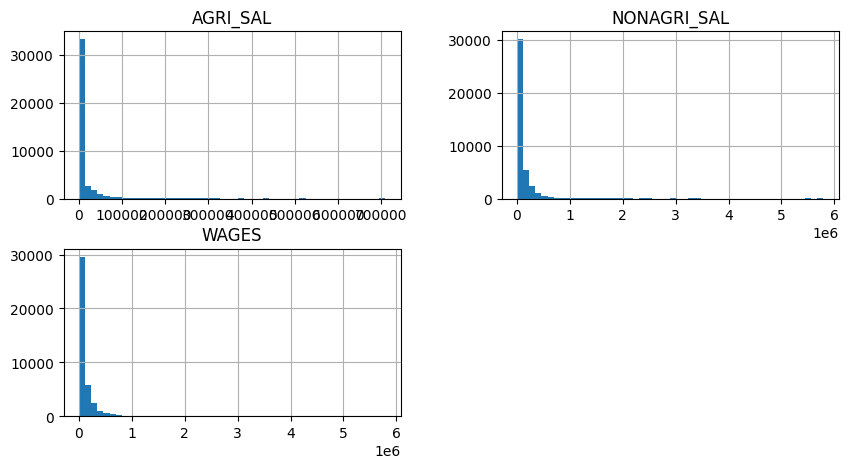

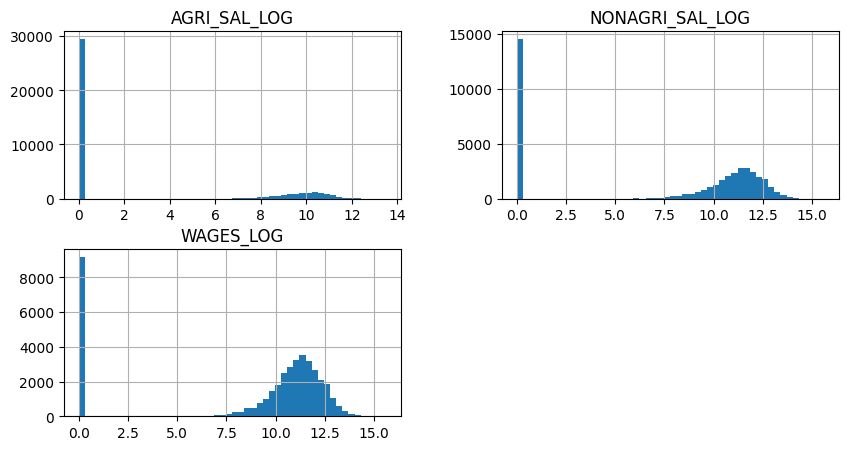

In [52]:
fies_df.boxplot(column='AGRI_SAL')
plt.title("Agri salary boxplot")
plt.show()

Since there are a lot of outliers, we will use `.describe()` to check the distribution.

In [53]:
fies_df['AGRI_SAL'].describe()

count     40171.000000
mean       8175.134973
std       21639.311112
min           0.000000
25%           0.000000
50%           0.000000
75%        2945.000000
max      709600.000000
Name: AGRI_SAL, dtype: float64

There are a lot of zero values possibly because these individuals are not involved with agriculture.

With this in mind, these zero values are valid.

At the same time, the extreme outlier values are also valid, since these salaries are possible (wording?).

### Log Transformation for **`AGRI_SAL`**, **`NONAGRI_SAL`**, & **`WAGES`**

Now, we will perform **Log Transformation**. This is done to reduce the impact of extreme values. 

Since log(0) is undefined, we will use **log1p** *( log(1 + x) )* to avoid errors.

Distribution **before** log transformation:

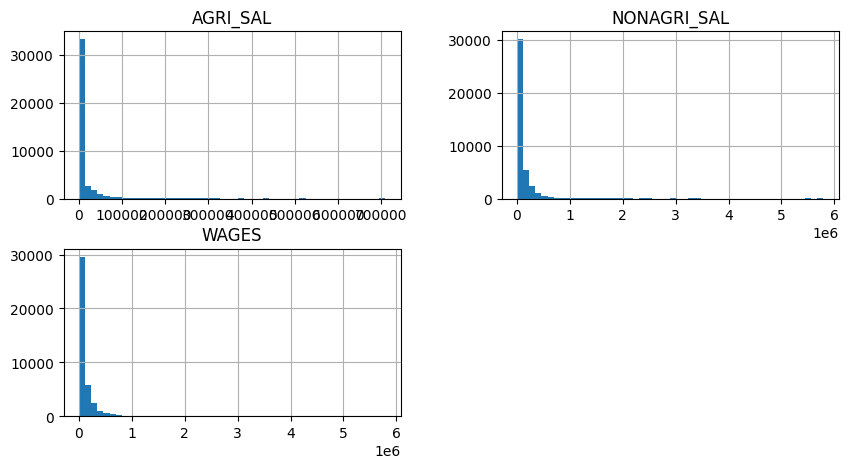

In [54]:
fies_df[['AGRI_SAL', 'NONAGRI_SAL', 'WAGES']].hist(figsize=(10, 5), bins=50)
plt.show()

In [55]:
fies_df['AGRI_SAL_LOG'] = np.log1p(fies_df['AGRI_SAL'])
fies_df['NONAGRI_SAL_LOG'] = np.log1p(fies_df['NONAGRI_SAL'])
fies_df['WAGES_LOG'] = np.log1p(fies_df['WAGES'])

Distribution **after** log transformation:

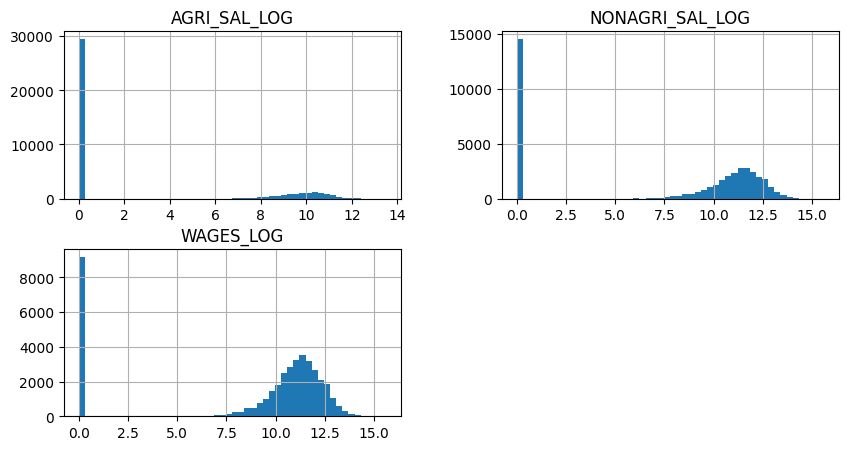

In [56]:
fies_df[['AGRI_SAL_LOG', 'NONAGRI_SAL_LOG', 'WAGES_LOG']].hist(figsize=(10, 5), bins=50)
plt.show()